In [1]:
from torchvision.models import vgg16
import os 
from PIL import Image  # Image Load
import numpy as np
from matplotlib import pyplot #to show image
import xml.etree.ElementTree as ET # to get bndbox
import torch
from torch import nn
import torchvision # .opt.nms
import torch.nn.functional as F # softmax
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import tarfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from torchvision.io import read_image

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.img_dir = os.path.join(data_dir, 'JPEGImages')
    self.anno_dir = os.path.join(data_dir, 'Annotations')
    self.ids = self.get_ids(self.img_dir)
    self.class_dict, self.class_names = self.get_dataset_info()
    self.transform = transform
    self.normalize = torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )
  def get_ids(self, img_dir):
    ids = []
    for file_name in os.listdir(img_dir):
      ids.append(file_name.split('.')[0])
    ids.sort()
    return ids

  def get_dataset_info(self):
    class_dict = {}
    class_names = []
    class_idx = 0
    for id in self.ids:
      anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
      for obj in anno.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_dict:
          class_dict[class_name] = class_idx
          class_idx += 1
          class_names.append(class_name)
    return class_dict, class_names

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, i):
    if i >= len(self.ids): print("ERROR, size exceeded")
  
   
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    image = np.transpose(image, (2, 0, 1))
    img_bndboxes = []
    img_classes = []

    #image = image.float()
    
    image = image / 256.
    image = torch.tensor(image, device=dev)#
    x = self.normalize(image)

    anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
    for obj in anno.findall('object'):
      class_name = obj.find('name').text
      img_classes.append(self.class_dict[class_name])
      
      bndbox = obj.find('bndbox')
      img_bndboxes.append(
          [float(bndbox.find(tag).text) - 1 for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
      )
    
    #print(image.shape)
    #x = torch.tensor(image, device=dev)#
    #print(X.shape)
    hh, ww = x.size(1), x.size(2)
    g_box = torch.tensor(img_bndboxes)
    g_cls = torch.tensor(img_classes)
    g_box[:, (0, 2)] /= ww
    g_box[:, (1, 3)] /= hh
    if self.transform:
      x = self.transform(x)
    
    sample = {"X":x, "G_box":g_box, "G_cls":g_cls}

    return sample
  
  def get_image(self, i):
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    return image


In [4]:
def batch_collate(batch_data):
  X = []
  G_imgidx, G_box, G_cls = [], [], []
  for i in range(len(batch_data)):
    ith_batch_data = batch_data[i]
    x, g_box, g_cls = ith_batch_data['X'], ith_batch_data['G_box'], ith_batch_data['G_cls']
    X.append(x)
    G_imgidx.append(torch.tensor([i]*len(g_box)))
    G_box.append(g_box)
    G_cls.append(g_cls)
  X = torch.stack(X, dim=0).to(dev)
  G_imgidx = torch.cat(G_imgidx, dim=0).to(dev)
  G_box = torch.cat(G_box, dim=0).to(dev)
  G_cls = torch.cat(G_cls, dim=0).to(dev)
  
  return X, G_box, G_cls, G_imgidx



In [5]:


tar = tarfile.open("drive/MyDrive/voctar")
tar.extractall()
tar.close()

In [6]:
#input : 448*448
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, input):
        return self.func(input)

darknet = nn.Sequential(
  nn.Conv2d(3, 64, 7, stride=2, padding=3),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(64, 192, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(192, 128, 1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(128, 256, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 256, 1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True), 
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 512, 1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1, inplace=True),

  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  Lambda(lambda x: x.view(-1, 1024*7*7)),
  #7*7*1024
  nn.Linear(7*7*1024, 4096), nn.LeakyReLU(0.1, inplace=True),
  nn.Dropout(p=0.5),
  nn.Linear(4096, 7*7*30),
  Lambda(lambda x: x.view(-1, 7, 7, 30)),
)

In [7]:
def get_anchor(B):
  assert B==5, 'B should be 5'
  anchor = [[0.1, 0.1],\
            [0.2, 0.2],\
            [0.3, 0.3],\
            [0.5, 0.5],\
            [0.7, 0.7]]
  return torch.tensor(anchor).to(dev)

A = get_anchor(5)

In [8]:
class Darknet(nn.Module):
  
  def __init__(self, darknet, C=20, S=13, B=5):
    super().__init__()
    self.darknet = darknet
    self.convnet = nn.Conv2d(512, C+B*4+B, 3, stride=1, padding=1)
    #self.convnet = convnet
    self.params = C, S, B
    
  def forward(self, X):
    C, S, B = self.params

    N = len(X)
    X.to(dev)

    _H = self.darknet(X.float())
    H = self.convnet(_H).permute(0, 2, 3, 1)
    H_cls = H[:, :, :, :C].clone()
    H_box = H[:, :, :, C:C+B*4].clone()
    H_conf = H[:, :, :, C+B*4:C+B*4+B].clone()
      
    H_cls = H_cls.view(N, -1, C)  
    H_cls = F.softmax(H_cls, dim=-1)
    
    H_box = H_box.view(N, -1, B, 4)
    H_box[:, :, :, 0:2] = torch.sigmoid(H_box[:, :, :, 0:2]) - 0.5 + y_center[None, :, None, :] # N S*S B 4
    H_box[:, :, :, 2:4] = A[None, None, :, :] * torch.exp(H_box[:, :, :, 2:4]) # N S*S B- 2-
  
    H_conf = H_conf.view(N, -1, B)
    H_conf = torch.sigmoid(H_conf)
    
    return H_cls, H_box, H_conf

In [9]:
class Convs(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_cls = nn.Conv2d(512, C, 1).to(dev)
    self.conv_box_offset = nn.Conv2d(512, B*4, 1).to(dev)
    self.conv_conf = nn.Conv2d(512, B, 1).to(dev)

  def forward(self, H):
    H_cls = self.conv_cls(H)
    H_box_offset = self.conv_box_offset(H)
    H_conf = self.conv_conf(H)
    H_cls = H_cls.permute(0, 2, 3, 1)
    H_box_offset = H_box_offset.permute(0, 2, 3, 1)
    H_conf = H_conf.permute(0, 2, 3, 1)
    return H_cls, H_box_offset, H_conf
#convs = Convs().to(dev)
#param1 = [p for p in vggmodel.parameters()]
#param2 = [p for p in convs.parameters()]


In [10]:
def get_y_center(S):
  print(np.linspace(0, 1, num=S, endpoint=False))
  _y_center = np.linspace(0, 1, num=S, endpoint=False) + (1/S)*0.5
  _y_center_x = _y_center[None, :] + np.zeros(S)[:, None]
  _y_center_y = _y_center[:, None] + np.zeros(S)[None, :]

  y_center = np.stack((_y_center_x, _y_center_y), axis=2)
  y_center= np.reshape(y_center, (-1, 2))
  y_center = torch.from_numpy(y_center).to(dev)
  return y_center
y_center = get_y_center(S=13)

[0.         0.07692308 0.15384615 0.23076923 0.30769231 0.38461538
 0.46153846 0.53846154 0.61538462 0.69230769 0.76923077 0.84615385
 0.92307692]


In [11]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
darknet.to(dev)
#list(p for p in darknet.parameters())[-4:]
opt = torch.optim.SGD(
    darknet.parameters(), lr=0.01, #weight_decay = 0.0005 #this caused error
)

In [12]:
def sum_sq_error(X, mask):
  loss = torch.pow(X, 2) * mask
  return torch.sum(loss)

In [13]:
def get_iou(h_box, y_box):
  #-iou-#
  #print(h_box.device, y_box.device)
  tl = torch.maximum(h_box[:, :, :2], y_box[:, None, :2]) # 49 2 2
  br = torch.minimum(h_box[:, :, 2:], y_box[:, None, 2:])

  iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1) # 49 2
  iou_a = torch.prod(h_box[:, :,  2:] - h_box[:, :, :2], axis=-1) # 49 2
  iou_b = torch.prod(y_box[:, 2:] - y_box[:, :2], axis=-1, keepdim=True) # 49 1
  iou = iou_inter / (iou_a + iou_b - iou_inter) # 49 2

  return iou

In [14]:
def get_Y_data(G_imgidx, G_box, G_cls, H_box):
  N = H_box.size(0)
  S2 = H_box.size(1)
  import math
  S = int(math.sqrt(S2))
  B = H_box.size(2)

  G_center = torch.stack(((G_box[:, 0] + G_box[:, 2])/2,
                              (G_box[:, 1] + G_box[:, 3])/2), axis=1).to(dev)
  G_sqrwh = torch.stack(((G_box[:, 2] - G_box[:, 0]),
                          G_box[:, 3] - G_box[:, 1]), axis=1).to(dev)
  _G_box = torch.stack((G_center, G_sqrwh), axis=1).view(-1, 4)
  
  _y_split = torch.linspace(start=1/S, end=1, steps=S).to(dev) 
  _x_off = _y_split[None, :] < G_center[:, 0, None]
  _y_off = _y_split[None, :] < G_center[:, 1, None]
  target_idx = (torch.sum(_x_off, dim=-1) + torch.sum(_y_off, dim=-1) * S).long().to(dev)
  
  Y_box = torch.zeros((N, S2, 4)).to(dev)
  Y_cls = torch.zeros((N, S2)).long().to(dev)
  Y_obj = torch.zeros((N, S2)).to(dev)
  Y_obj_ij = torch.zeros((N, S2, B)).to(dev)

  for i in range(N):

    ith_batch_idx = (G_imgidx == i).nonzero()
    g_target_idx = target_idx[ith_batch_idx]
    g_box = _G_box[ith_batch_idx]
    g_cls = G_cls[ith_batch_idx]
    h_box = H_box[i]

    #Y_box, Y_cls
    Y_box[i][g_target_idx] = g_box
    Y_cls[i][g_target_idx] = g_cls
    Y_obj[i][g_target_idx] = 1
    #print(F.one_hot(max_iou_idx(h_box, Y_box[i]), num_classes=2).shape)
    iou = get_iou(h_box, Y_box[i])
    max_iou_idx = torch.argmax(iou, axis=1)
    Y_obj_ij[i] = F.one_hot(max_iou_idx, num_classes=B) \
      * Y_obj[i, :, None] #N, 49, 2 -- N, 49
  Y_obj_ij.detach_()
  Y_conf = Y_obj_ij
  return Y_box, Y_cls, Y_obj, Y_obj_ij, Y_conf

In [15]:
def get_loss(l_coord, l_noobj, H_box, Y_box, Y_obj_ij, H_conf, Y_conf, H_cls, Y_cls, Y_obj):
  C = H_cls.size(2) #N S*S C
  
  l1 = l_coord * sum_sq_error(H_box[:, :, :, 0] - Y_box[:, :, None, 0], Y_obj_ij)
  l2 = l_coord * sum_sq_error(H_box[:, :, :, 1] - Y_box[:, :, None, 1], Y_obj_ij)
  l3= l_coord * sum_sq_error(torch.sqrt(H_box[:, :, :, 2]) \
    - torch.sqrt(Y_box[:, :, None, 2]), Y_obj_ij)
  l4= l_coord * sum_sq_error(torch.sqrt(H_box[:, :, :, 3]) \
    - torch.sqrt(Y_box[:, :, None, 3]), Y_obj_ij)
  l5=  sum_sq_error(H_conf - Y_conf, Y_obj_ij == 1)
  l6=  l_noobj * sum_sq_error(H_conf - Y_conf, Y_obj_ij == 0)
  l7=  sum_sq_error(H_cls - F.one_hot(Y_cls, num_classes=C), Y_obj[:, :, None])
  L = l1 + l2 + l3 + l4 + l5 + l6 + l7
  #print(H_conf, H_cls)
  print(f'  LOSS: , {L.item()}, {l1.item()}, {l2}, {l3}, {l4}, {l5}, {l6}, {l7.item()}')

  return L

In [16]:
def train(n_epochs, model, train_dl, opt, l_coord=5, l_noobj=0.1):
  model.train()
  for epoch_idx in range(n_epochs):
    for batch_idx, data in enumerate(train_dl):
      X, G_box, G_cls, G_imgidx = data
      X.to(dev), G_box.to(dev), G_cls.to(dev)
      opt.zero_grad()

      H_cls, H_box, H_conf = model(X.float())
      Y_box, Y_cls, Y_obj, Y_obj_ij, Y_conf = get_Y_data(G_imgidx, G_box, G_cls, H_box)
      L = get_loss(l_coord, l_noobj, H_box, Y_box, Y_obj_ij, H_conf, Y_conf, H_cls, Y_cls, Y_obj)
      L.backward()

      #nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      opt.step()
      break


In [17]:
def eval(n_epochs, model, eval_dl):
  model.eval()
  for batch_idx, data in enumerate(eval_dl):
    X, G_box, G_cls, G_imgidx = data
    X.to(dev), G_box.to(dev), G_cls.to(dev)

    H_cls, H_box, H_conf = model(X.float())
    Y_box, Y_cls, Y_obj, Y_obj_ij, Y_conf = get_Y_data(G_imgidx, G_box, G_cls, H_box)
    L = get_loss(l_coord, l_noobj, H_box, Y_box, Y_obj_ij, H_conf, Y_conf, H_cls, Y_cls, Y_obj)
 

    pred_boxes_indices = torchvision.ops.nms(boxes=H_box.float(), scores=H_conf, iou_threshold=0.7)
    Y_pred_boxes = H_box[pred_boxes_indices]
    Y_pred_cls = H_cls[(pred_boxes_indices/B).long()]
    Y_boxes = G_box.view(-1, 4)
    Y_cls = G_cls.view(-1)



In [18]:
def mAP(Y_pred_boxes, Y_pred_cls, G_box, G_cls, G_imgidx):
  return

In [19]:
def predict(model, i, conf_lb=0.5, print_ground=False):
  data = imageDataset[i]
  X, G_box, G_cls = data["X"], data["G_box"], data["G_cls"]
  X = X[None, :]
  G_box = G_box[None, :]
  G_cls = G_cls[None, :]
  X.to(dev), G_box.to(dev), G_cls.to(dev)
  

  model.eval()
  with torch.no_grad():  
    H_cls, H_box, H_conf = model(X.float())
    B = H_box.size(2) #N S2 B
    S2 = H_box.size(1)
    C = H_cls.size(2)
    _H_conf = H_conf.reshape(S2*B)
    _H_box = H_box.reshape(S2*B, 4)
    _H_cls = H_cls.reshape(S2, C)  

    
    H_box_sltd = _H_box[_H_conf > conf_lb]
    H_cls_sltd = _H_cls[torch.any(_H_conf.reshape(S2, B) > conf_lb, dim=1)]
    H_conf_sltd = _H_conf[_H_conf > conf_lb]

    pred_boxes_indices = torchvision.ops.nms(boxes=H_box_sltd.float(), scores=H_conf_sltd, iou_threshold=0.7)
    Y_pred_boxes = H_box_sltd[pred_boxes_indices]
    Y_pred_cls = H_cls_sltd[(pred_boxes_indices/B).long()]
    
    image = np.array(imageDataset.get_image(i))
    hh = image.shape[0]
    ww = image.shape[1]
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig = plt.figure(i)
    #print(X[1].shape)
    plt.imshow(image)
    
    #plt.plot(y_center[:, 0].cpu().numpy()*ww, y_center[:, 1].cpu().numpy()*hh, 'o')
    if print_ground:
      #Y_box, Y_cls, Y_obj, Y_obj_ij, Y_conf = get_Y_data(G_imgidx, G_box, G_cls, H_box)
      Y_boxes = G_box.view(-1, 4)
      Y_cls = G_cls.view(-1)
      for j in range(len(Y_boxes)):
        g_box = Y_boxes[j]
        xx = g_box[0] * ww
        xy = g_box[1] * hh
        yx = g_box[2] * ww
        yy = g_box[3] * hh
        w = yx-xx
        h = yy-xy
        plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='b',facecolor='none'))
      
    for j in range(len(Y_pred_boxes)):
      pred_box = Y_pred_boxes[j]
      xc = pred_box[0] * ww
      yc = pred_box[1] * hh
      w = pred_box[2] * ww
      h = pred_box[3] * hh
      xx = xc - w/2
      xy = yc - h/2
      #print(xx, xy, w, h)
      print(xc.data, yc.data, w.data, h.data)
      plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))


In [20]:
imageDataset = ImageDataset('VOCdevkit/VOC2007', torchvision.transforms.Resize((416, 416)))
#print(imageDataset[0]['G_box'])

In [21]:
train_dl = DataLoader(imageDataset, batch_size=16, shuffle=False, collate_fn = batch_collate)#num_workers=1)
#next(iter(train_dl))

In [22]:
###MODEL###

vgg16 = torchvision.models.vgg16_bn(pretrained=True)
darknet = nn.Sequential(
  vgg16.features,                     
  #nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #downsample by 32.
)

darknet_model = Darknet(darknet)
optimizer = torch.optim.Adam(
    darknet_model.parameters(), lr=0.0001, #weight_decay = 0.0005 #this caused error
)
darknet_model.to(dev)
1
print(dev)

cuda


In [23]:
torch.cuda.is_available()

True

In [24]:
###train and predict###
train(n_epochs=30, model=darknet_model, train_dl=train_dl, opt=optimizer)


  LOSS: , 417.5311584472656, 0.851447582244873, 1.3057459592819214, 17.520200729370117, 22.17577362060547, 9.7504243850708, 327.71453857421875, 38.21304702758789
  LOSS: , 372.6282043457031, 0.19175565242767334, 0.38585710525512695, 9.629501342773438, 13.677947998046875, 9.30368423461914, 302.0773010253906, 37.36215591430664
  LOSS: , 337.3238525390625, 0.2225441038608551, 0.35248133540153503, 8.149226188659668, 8.972625732421875, 8.850166320800781, 274.74517822265625, 36.031612396240234
  LOSS: , 304.1750183105469, 0.20819944143295288, 0.3234134614467621, 3.9409279823303223, 6.8433637619018555, 8.814079284667969, 249.6165771484375, 34.4284553527832
  LOSS: , 273.3978271484375, 0.15162616968154907, 0.2274390310049057, 2.927656650543213, 3.233956813812256, 8.974924087524414, 225.6501007080078, 32.23211669921875
  LOSS: , 246.84771728515625, 0.12334860861301422, 0.17030148208141327, 2.6719932556152344, 1.7052347660064697, 8.80103874206543, 204.01158142089844, 29.36421775817871
  LOSS: , 

tensor(187.5513, device='cuda:0') tensor(209.3004, device='cuda:0') tensor(83.6535, device='cuda:0') tensor(120.8470, device='cuda:0')
tensor(278.4286, device='cuda:0') tensor(258.9223, device='cuda:0') tensor(43.4193, device='cuda:0') tensor(103.2863, device='cuda:0')
tensor(166.3900, device='cuda:0') tensor(243.4285, device='cuda:0') tensor(168.8162, device='cuda:0') tensor(127.0692, device='cuda:0')


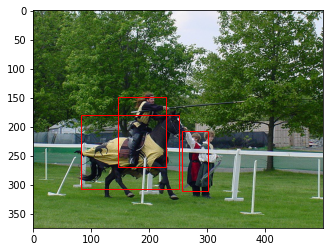

In [31]:
predict(model=darknet_model, i=2, conf_lb=0.5, print_ground=False)

In [26]:
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda= lambda epoch:
                                              1 if epoch < 1 else \
                                              10 if epoch < 75 else \
                                              1 if epoch < 105 else \
                                              0.1 if epoch < 135 else 1
)